# Perceptrons, Multilayer Perceptrons, and Convolutional Neural Networks

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam

2023-03-01 03:34:29.688419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sns.set_theme()

## Load Data & Preprocess

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Scale to [-1, 1]
n_train = x_train.shape[0]
n_test = x_test.shape[0]
n_features = np.prod(x_train.shape[1:])

x_train = StandardScaler().fit_transform(x_train.reshape(n_train, n_features))
x_test = StandardScaler().fit_transform(x_test.reshape(n_test, n_features))

# Perceptron

- Binary classifier for $\sigma\left(b+\sum_{i=1}^n x_i w_i\right)$

In [5]:
target_one = 7
target_two = 8

labels: np.ndarray = (y_train == target_one) + (y_train == target_two)

x_train_target, y_train_target = x_train[labels,:], y_train[labels]*1.

y_train_target[y_train_target == target_one] = -1
y_train_target[y_train_target == target_two] = 1

labels: np.ndarray = (y_test == target_one) + (y_test == target_two)
x_test_target, y_test_target = x_test[labels,:], y_test[labels]*1.

y_test_target[y_test_target == target_one] = -1
y_test_target[y_test_target == target_two] = 1

In [6]:
def predict(x: np.ndarray, w: np.ndarray, b: np.ndarray):
    # Compute the dot product of the input and the weights plus bias
    product = np.matmul(w, x) + b
    # Sum the resulting matrix
    sum = np.sum(product)
    # Take the sign of the sum as the activation
    return 1 if sum >= 0 else -1

In [7]:
training_loss_per_iteration = []
validation_loss_per_iteration = []

def optimize(x, y):
  iter = 0
  error = np.inf
  # n samples, m features
  n, m = x.shape
  # w is a vector of m weights
  w = np.random.rand(m)
  # b is the bias term, treated as though w_0
  b = np.random.rand()
  # r is the learning rate hyperparameter
  r = 0.001
  # converge until performance is adequate or max iterations reached
  training_loss = float('inf')
  while (iter < 1000) and (training_loss > 1e-2):
    iter += 1
    # the number of incorrect predictions over this iteration
    train_err_count = 0
    for i in range(n):
      # sample is an image from the training set
      sample = x[i]
      # y_true is the ground truth, the label of the image
      y_true = y[i]
      # y_pred is the prediction of the perceptron
      y_pred = predict(sample, w, b)
      # if the prediction is incorrect, update the weights
      if y_pred != y_true:
        # if y_true = -1, then if r = 1, r * sign = -2, else 2
        # so r scales the weights
        sign = y_true - y_pred
        w = w + r * sign * sample
        b = b + r * sign * sample
        train_err_count += 1

    training_loss = train_err_count / n
    training_loss_per_iteration.append(train_err_count / n)

    val_err_count = 0
    # Compute the validation loss
    for i in range(x_test_target.shape[0]):
      sample = x_test_target[i]
      y_true = y_test_target[i]
      y_pred = predict(sample, w, b)
      if y_pred != y_true:
        val_err_count += 1
    validation_loss_per_iteration.append(val_err_count / x_test_target.shape[0])

  return w, b, error

w_trained, b_trained, error_trained = optimize(x_train_target, y_train_target)

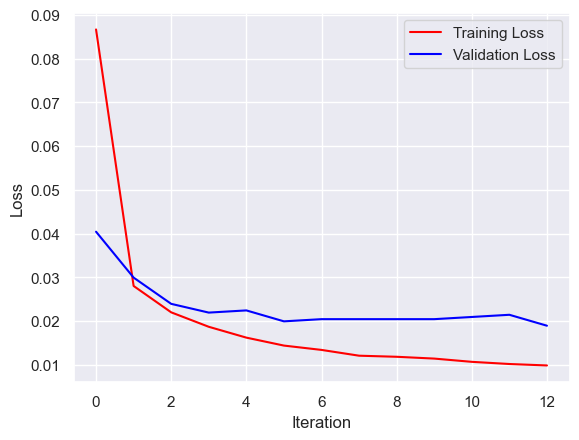

In [8]:
training_loss_df = pd.DataFrame(training_loss_per_iteration)
validation_loss_df = pd.DataFrame(validation_loss_per_iteration)

fig, ax = plt.subplots()
sns.lineplot(data=training_loss_per_iteration, color="red", label="Training Loss")
sns.lineplot(data=validation_loss_per_iteration, color="blue", label="Validation Loss")
# sns.lineplot(data=pd.concat([training_loss_df, validation_loss_df]))
ax.set(xlabel='Iteration', ylabel='Loss')
plt.show()

<AxesSubplot: >

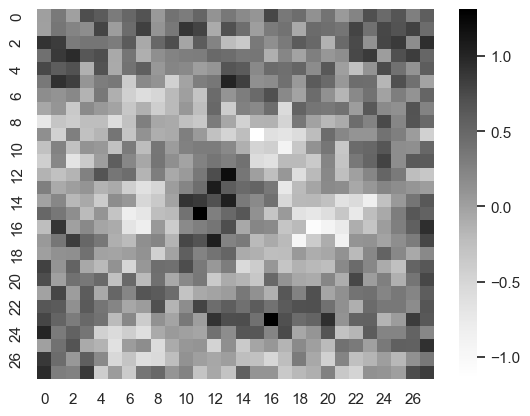

In [9]:
# A heatmap representation of the weights
sns.heatmap(w_trained.reshape(28, 28), cmap="Greys")

## Neural Networks

In [10]:
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

BATCH_SIZE = 50
EPOCHS = 10
LEARNING_RATE = 0.001

In [11]:
model = Sequential()
# 28x28 = 784 inputs, the length of the flattened image
model.add(Dense(1000, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(1000))
model.add(Activation('relu'))
# target 10 classes
model.add(Dense(10))
# produce a probability distribution
model.add(Activation('softmax'))

optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

2023-03-01 03:34:37.754527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
history = model.fit(
  x=x_train, 
  y=y_train,
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS,
  verbose=1,
  validation_data=(x_test,y_test))

Epoch 1/10
1200/1200 [==============================] - 16s 12ms/step - loss: 0.2490 - accuracy: 0.9345 - val_loss: 0.2145 - val_accuracy: 0.9497
Epoch 2/10
1200/1200 [==============================] - 19s 15ms/step - loss: 0.1299 - accuracy: 0.9675 - val_loss: 0.1288 - val_accuracy: 0.9672
Epoch 3/10
1200/1200 [==============================] - 16s 13ms/step - loss: 0.0865 - accuracy: 0.9757 - val_loss: 0.1402 - val_accuracy: 0.9665
Epoch 4/10
1200/1200 [==============================] - 16s 13ms/step - loss: 0.0712 - accuracy: 0.9803 - val_loss: 0.1533 - val_accuracy: 0.9669
Epoch 5/10
1200/1200 [==============================] - 16s 14ms/step - loss: 0.0658 - accuracy: 0.9828 - val_loss: 0.1567 - val_accuracy: 0.9706
Epoch 6/10
1200/1200 [==============================] - 17s 14ms/step - loss: 0.0679 - accuracy: 0.9834 - val_loss: 0.1915 - val_accuracy: 0.9700
Epoch 7/10
1200/1200 [==============================] - 16s 13ms/step - loss: 0.0519 - accuracy: 0.9880 - val_loss: 0.1572 -

In [13]:
print("Training accuracy: " + str(history.history['accuracy'][-1]*100)[:6] + "%")
print("Test accuracy: " + str(history.history['val_accuracy'][-1]*100)[:6] + "%")

Training accuracy: 99.011%
Test accuracy: 97.089%


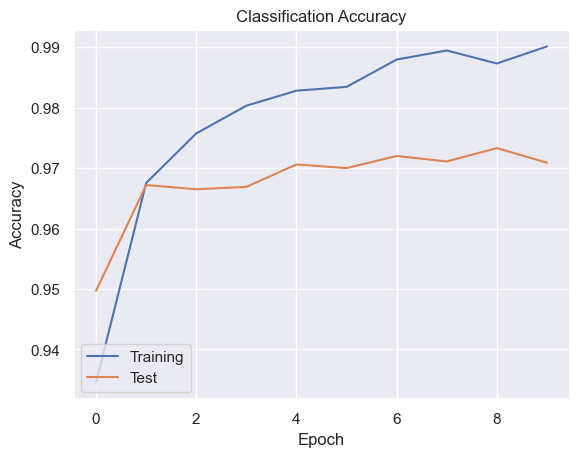

In [14]:
# Classification accuracy with train and test set
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='lower left')
plt.show()

## Convolutional Neural Networks

In [15]:
h_w_dim = int(np.sqrt(n_features))
x_train.resize([n_train, h_w_dim, h_w_dim])
x_test.resize([n_test, h_w_dim, h_w_dim])

In [16]:
KERNEL_SIZE = (4,4)

cnn_model=Sequential()

cnn_model.add(Conv2D(filters=32, strides=1, kernel_size=KERNEL_SIZE, activation="relu", input_shape=(28,28,1)))
cnn_model.add(Conv2D(filters=64, strides=2, kernel_size=KERNEL_SIZE, activation="relu"))
cnn_model.add(Conv2D(filters=128, strides=2, kernel_size=KERNEL_SIZE, activation="relu"))
cnn_model.add(Flatten())
cnn_model.add(Dense(10,activation="softmax"))
    
cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
cnn_history = cnn_model.fit(
  x=x_train, 
  y=y_train,
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS,
  verbose=1,
  validation_data=(x_test,y_test))

Epoch 1/10
1200/1200 [==============================] - 39s 32ms/step - loss: 0.1266 - accuracy: 0.9621 - val_loss: 0.0438 - val_accuracy: 0.9865
Epoch 2/10
1200/1200 [==============================] - 37s 31ms/step - loss: 0.0426 - accuracy: 0.9869 - val_loss: 0.0407 - val_accuracy: 0.9875
Epoch 3/10
1200/1200 [==============================] - 46s 39ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.0461 - val_accuracy: 0.9855
Epoch 4/10
1200/1200 [==============================] - 42s 35ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0397 - val_accuracy: 0.9893
Epoch 5/10
1200/1200 [==============================] - 42s 35ms/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.0327 - val_accuracy: 0.9912
Epoch 6/10
1200/1200 [==============================] - 42s 35ms/step - loss: 0.0146 - accuracy: 0.9951 - val_loss: 0.0462 - val_accuracy: 0.9894
Epoch 7/10
1200/1200 [==============================] - 43s 35ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0450 -

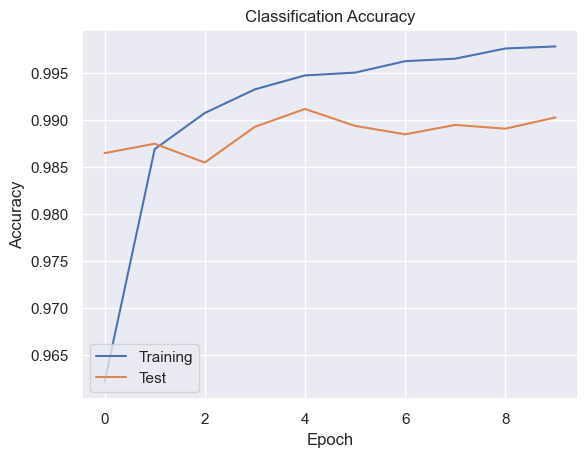

In [18]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='lower left')
plt.show()